# Subgroup comparison
In response to reviewer comments perform comparative analysis of top 20% and bottom 20% subgroups

In [60]:
import pickle
from pathlib import PurePath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
notebook_save_name = '1.0-subgroup-comparison:'

# Set font type to TrueType (Type 42) to allow text editing in Illustrator
# (Need to Install "DejaVu Sans Book" using Adobe Fonts for best compatibility)
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'sans-serif',
    'font.sans-serif': 'DejaVu Sans'
    })

In [3]:
# Read in subgroup results
subgroup_dir = PurePath('../results/subgroup_discovery/metabolic_health_index/')
with open(subgroup_dir.joinpath('AUROC_bottleneck_results.pkl'), 'rb') as f:
    subgroup_results = pickle.load(f)

In [4]:
# Read in top K subgroup predictions
top_k_preds = pd.read_csv(subgroup_dir.joinpath('top_k_subgroup_predictions.csv'))

In [5]:
# Get gestational age and birthweight from metadata
meta = pd.read_csv('../data/processed/metadata.csv', low_memory=False).set_index('row_id')
preterm_ga = [
    '22_23', 
    '24_25',
    '26_27',
    '28_29'
]
gabw = meta[['gacat', 'bwtcat']].query('gacat in @preterm_ga')
# gabw

In [6]:
subgroup_comp = gabw.copy()

In [7]:
# Then compare top K predictions for each outcome in terms of gestational age and birthweight
all_outcomes = ['bpd_any', 'rop_any', 'ivh_any', 'nec_any']
outcome = 'bpd_any'

outcome_comp = subgroup_comp.copy()
outcome_comp.gacat = outcome_comp.gacat.astype('category')
outcome_comp.bwtcat = pd.Categorical(outcome_comp.bwtcat, categories=reversed(sorted(outcome_comp.bwtcat.unique())))
outcome_top_k = top_k_preds.query('outcome == @outcome').copy()
outcome_comp[f'in_{outcome}_top_k'] = outcome_comp.index.isin(outcome_top_k['row_id'])
outcome_comp = outcome_comp.sort_values(f'in_{outcome}_top_k')

<Axes: xlabel='gacat', ylabel='bwtcat'>

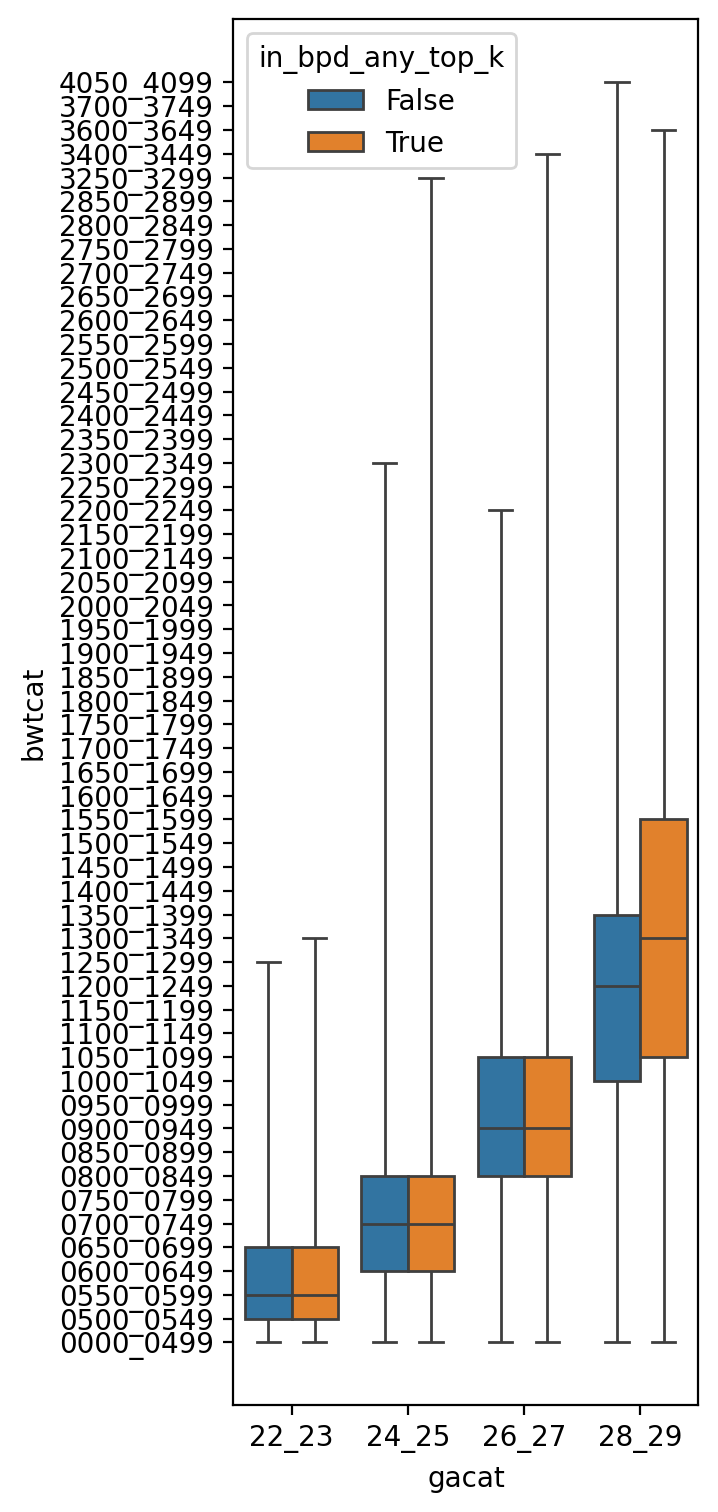

In [11]:
fig, ax = plt.subplots(figsize=(3, 9), dpi=200)
sns.boxplot(
    data=outcome_comp,
    x='gacat',
    y='bwtcat',
    hue=f'in_{outcome}_top_k',
    ax=ax, whis=(0, 100))

In [13]:
outcome_colors = {
    'bpd_any': '#4e79a7',
    'rop_any': '#76b7b2',
    'nec_any': '#e15759',
    'ivh_any': '#f28e2b'}

In [19]:
outcome

'nec_any'

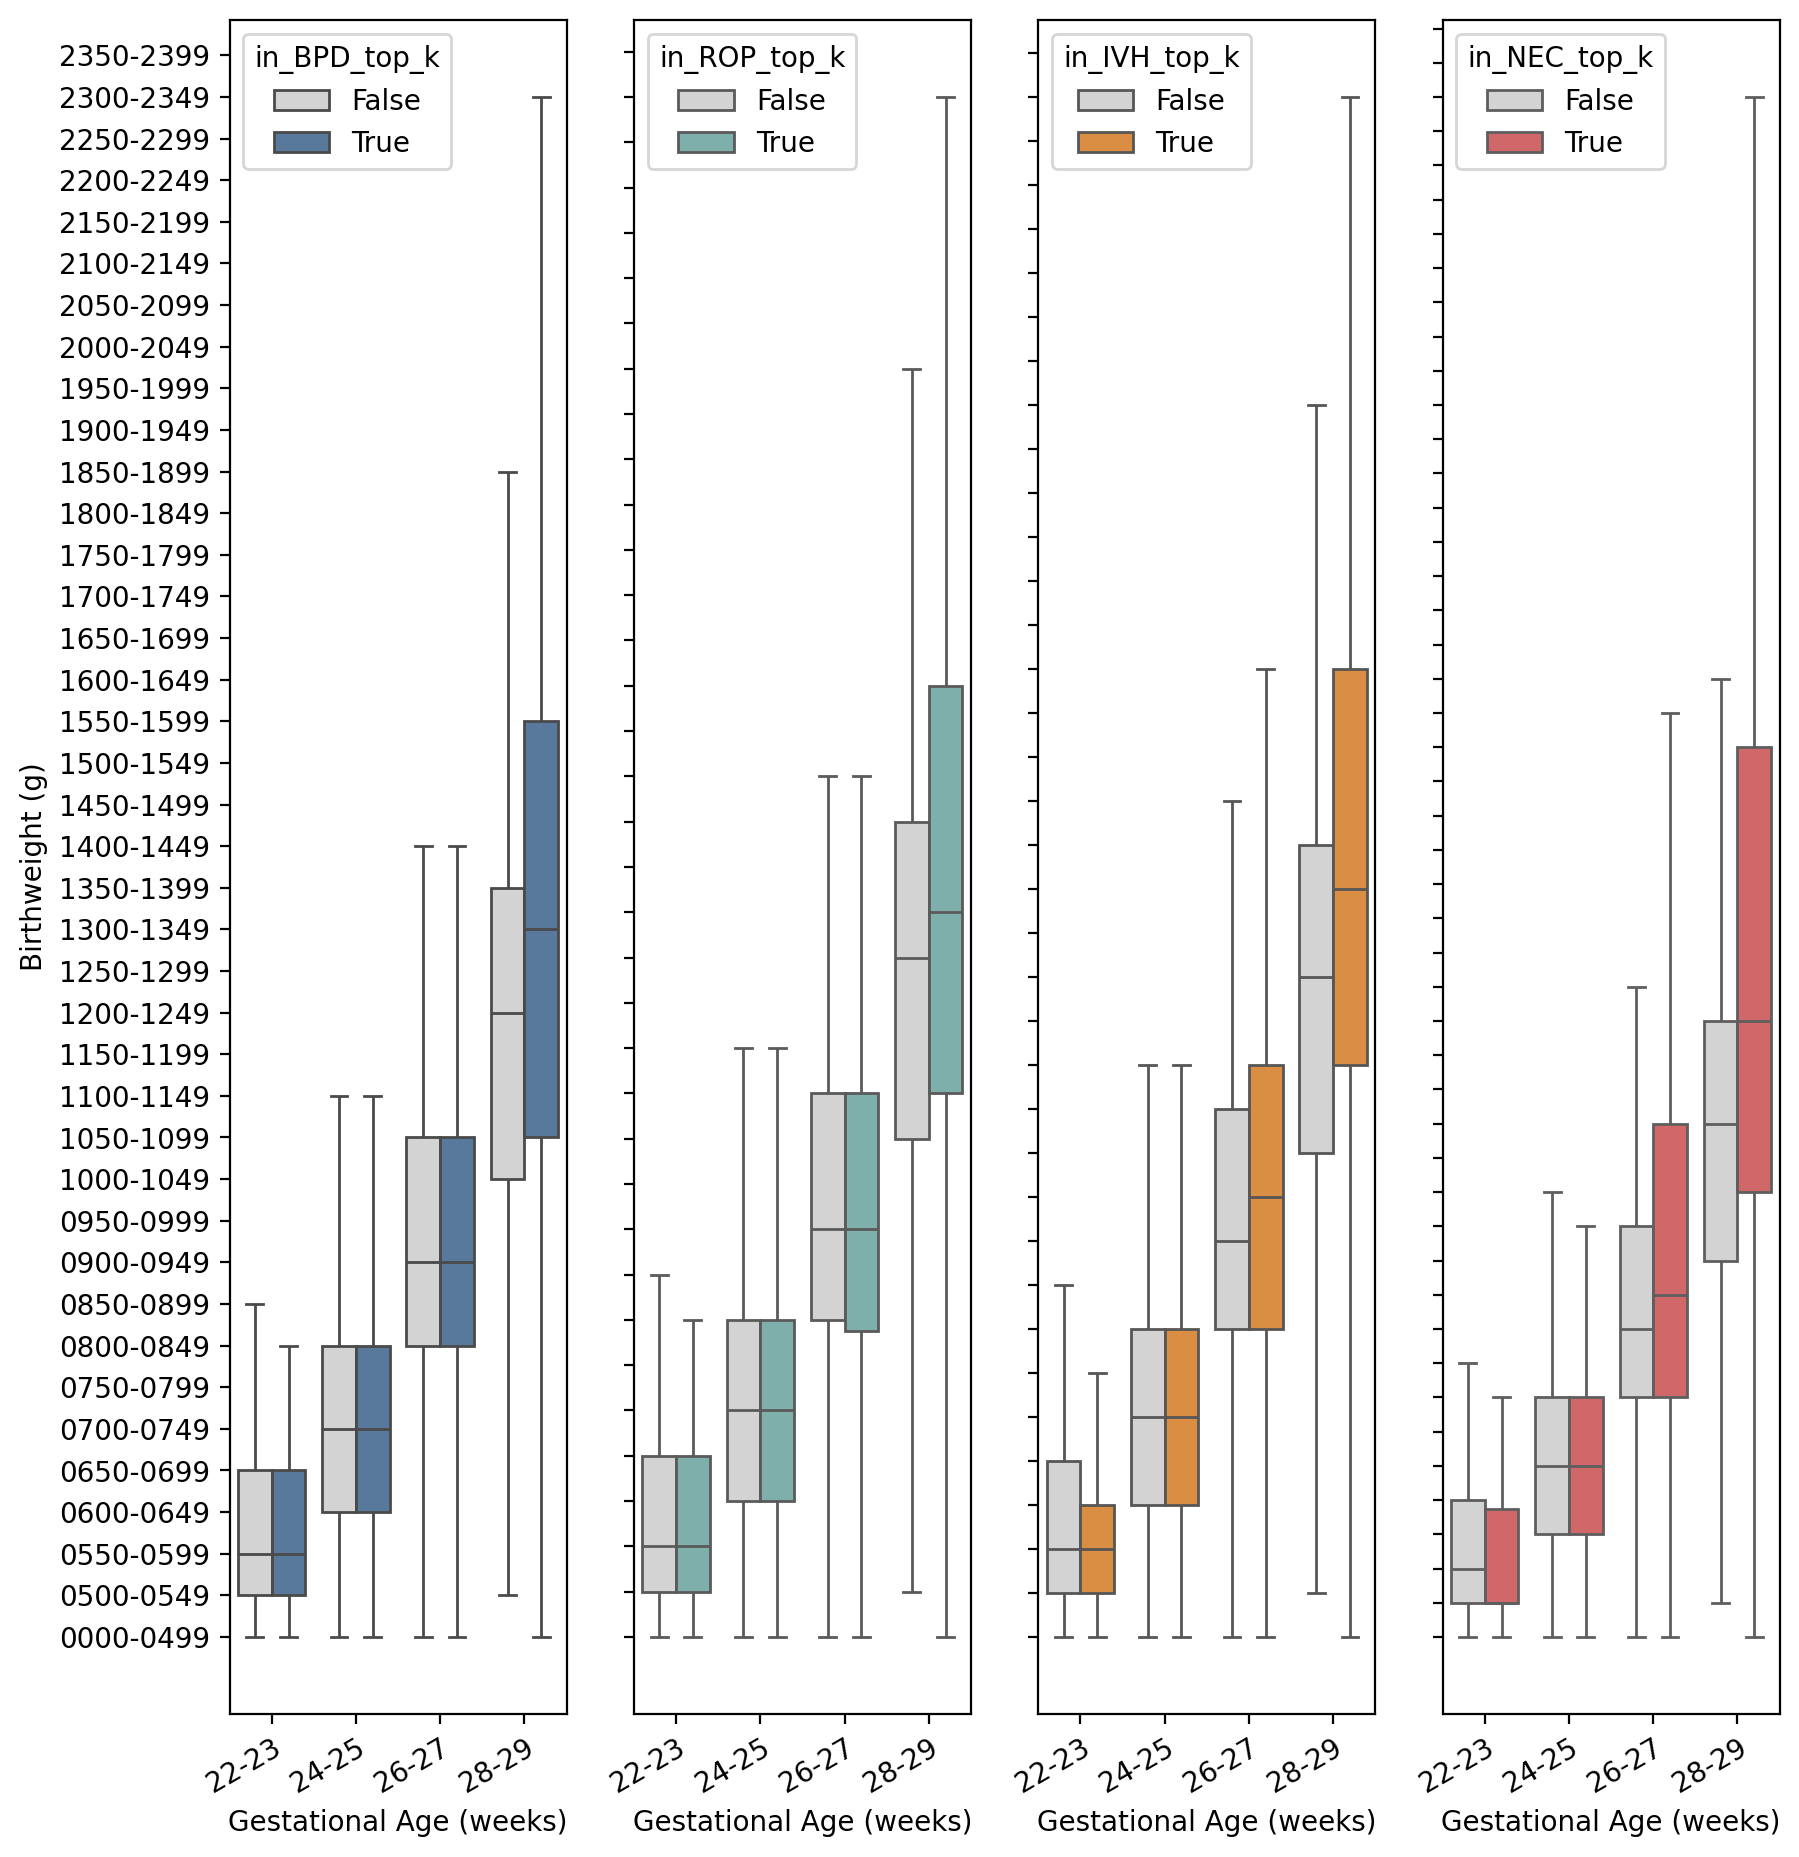

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 11), dpi=200)
outcome_comp['gacat'] = outcome_comp['gacat'].str.replace('_', '-')
outcome_comp['bwtcat'] = outcome_comp['bwtcat'].str.replace('_', '-')
outcome_comp.gacat = outcome_comp.gacat.astype('category')
outcome_comp.bwtcat = pd.Categorical(outcome_comp.bwtcat, categories=reversed(sorted(outcome_comp.bwtcat.unique())))

for i, (outcome, ax) in enumerate(zip(all_outcomes, axs.ravel())):
    outcome_top_k = top_k_preds.query('outcome == @outcome').copy()
    outcome_comp[f'in_{outcome}_top_k'] = outcome_comp.index.isin(outcome_top_k['row_id'])
    outcome_comp = outcome_comp.sort_values(f'in_{outcome}_top_k')
    np.random.seed(101)
    g = sns.boxplot(
        data=outcome_comp,
        x='gacat',
        y='bwtcat',
        hue=f'in_{outcome}_top_k',
        ax=ax,
        hue_order=[False, True],
        palette={True: outcome_colors[outcome], False: 'lightgrey'},
        showfliers=False)

    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
    ax.set_xlabel('Gestational Age (weeks)')
    ax.set_ylabel('Birthweight (g)')

    outcome_title = outcome.rstrip('_any').upper()
    ax.get_legend().set_title(f'in_{outcome_title}_top_k')
    if i >= 1:
        g.set(yticklabels=[], ylabel=None)

fig.savefig(f'figure_panels/{notebook_save_name}topk_gabw_compare.pdf')

In [21]:
outcome_comp

,gacat,bwtcat,in_bpd_any_top_k,in_rop_any_top_k,in_ivh_any_top_k,in_nec_any_top_k
row_id,,,,,,
1,26-27,1050-1099,False,False,False,False
8070,26-27,0900-0949,False,False,False,False
8083,28-29,1450-1499,False,False,False,False
8221,28-29,0850-0899,False,False,False,False
7830,28-29,1250-1299,False,False,False,False
...,...,...,...,...,...,...
1278,26-27,1650-1699,True,True,True,True
24923,26-27,2050-2099,True,True,True,True
38422,28-29,1950-1999,True,True,True,True


In [ ]:
outcome_comp_long = pd.melt(
    outcome_comp.reset_index(),
    id_vars=['row_id', 'gacat', 'bwtcat'],
    var_name='outcome', value_name='in_top_k')
outcome_comp_long.outcome = outcome_comp_long.outcome.str.removesuffix('_any_top_k')
outcome_comp_long.outcome = outcome_comp_long.outcome.str.removeprefix('in_')

,row_id,gacat,bwtcat,outcome,in_top_k
0,1,26-27,1050-1099,bpd,False
1,8070,26-27,0900-0949,bpd,False
2,8083,28-29,1450-1499,bpd,False
3,8221,28-29,0850-0899,bpd,False
4,7830,28-29,1250-1299,bpd,False
...,...,...,...,...,...
54139,1278,26-27,1650-1699,nec,True
54140,24923,26-27,2050-2099,nec,True
54141,38422,28-29,1950-1999,nec,True
54142,3045,28-29,0900-0949,nec,True


In [ ]:
from scipy.stats import mannwhitneyu
from pandas.api.types import is_numeric_dtype

def test_top_k_groups(df, col_var, in_top_k_col='in_top_k'):
    df = df.copy()
    # convert_col_var to numeric
    if not is_numeric_dtype(df[col_var]):
        # Create dummy numeric value within half the range
        range_split = df[col_var].str.split('-', expand=True).astype(float)
        range_lhs = range_split[0]
        range_rhs = range_split[1]
        df[col_var] = (range_lhs + range_rhs) / 2

    # Perform wilcoxon test
    in_top_k = df.query(f'{in_top_k_col} == True')[col_var].values
    out_of_top_k = df.query(f'{in_top_k_col} == False')[col_var].values

    test = mannwhitneyu(in_top_k, out_of_top_k)
    return test.pvalue

In [ ]:
bwtcat_test_across_ga = (
    outcome_comp_long.groupby(['outcome', 'gacat'])
    .apply(lambda x: test_top_k_groups(x, col_var='bwtcat')))
pval_colname = 'Mann-Whitney P Value'
bwtcat_test_across_ga.name = pval_colname

# Bonferroni Correction
bwtcat_pval_df = pd.DataFrame(bwtcat_test_across_ga.reset_index())
bwtcat_pval_df['Bonferroni-Corrected P Value'] = np.minimum(
    bwtcat_pval_df[pval_colname] * len(bwtcat_pval_df),
    1.0
)
bwtcat_pval_df.outcome = bwtcat_pval_df.outcome.str.upper()
bwtcat_pval_df.rename(columns={'gacat': 'gest_age_wks'}, inplace=True)
bwtcat_pval_df.to_csv(f'output/{notebook_save_name}birthweight_pvalues_in_ga_ranges.csv', index=False)

## Other comparisons on the top-K vs other subgroup side

In [ ]:
compare_columns = [
    'mrace_catm', # Mother's race/ethnicity
    'mage_catm2', # Mother's age
    'frace_catm', # Father's race/ethnicity
    'sex3', # Infant's sex at birth
]
extended_compare = pd.merge(outcome_comp, meta[compare_columns], left_index=True, right_index=True)

# And recategorize the columns based on keys
race_ethnicity_key = {
    1: 'Non-Hispanic White',
    2: 'Non-Hispanic Black',
    3: 'Asian',
    4: 'Pacific Islander',
    5: 'Hispanic',
    6: 'American Indian/Alaskan Native',
    7: 'Other',
    99: np.nan
}
age_categorical_key = {
    1: '11-19',
    2: '20-24',
    3: '25-29',
    4: '30-34',
    5: '35-39',
    6: '40-44',
    7: '45-70',
    99: np.nan
}
infant_sex_categorical_key = {
    1: 'Male',
    2: 'Female'
}

extended_compare = extended_compare.replace(
    {
        'mrace_catm': race_ethnicity_key,
        'mage_catm2': age_categorical_key,
        'frace_catm': race_ethnicity_key,
        'sex3': infant_sex_categorical_key
    }
)

extended_compare.rename(
    columns={
        'mrace_catm': 'maternal_race_ethnicity',
        'frace_catm': 'paternal_race_ethnicity',
        'mage_catm2': 'maternal_age',
        'sex3': 'infant_sex'},
    inplace=True)
# extended_compare

### Compare distribution of comparison groups across cases and controls

In [ ]:
# Read in true labels for BPD, NEC, ROP, and IVH
outcome_labels = pd.read_csv('../data/processed/neonatal_conditions.csv', low_memory=False).set_index('row_id')[all_outcomes]
extended_outcome_compare = pd.merge(extended_compare, outcome_labels, left_index=True, right_index=True)

extended_outcome_compare.to_csv('intermediate_output/bwtcat_topk_covariates_labels.csv', index=True)
# extended_outcome_compare

In [ ]:
# Evaluate a difference in distribution across outcomes
# and in top K groups per outcome
updated_compare_columns = ['maternal_race_ethnicity', 'paternal_race_ethnicity', 'infant_sex', 'maternal_age']
compare_dfs = {k: [] for k in updated_compare_columns}
compare_topk_dfs = {k: [] for k in updated_compare_columns}

for outcome in all_outcomes:
    outcome_df = extended_outcome_compare[[outcome, f'in_{outcome}_top_k'] + updated_compare_columns]
    for comparison in updated_compare_columns:
        # First do outcomes only
        counts_df = outcome_df[[outcome, comparison]]
        counts = counts_df.groupby(outcome).value_counts()
        # NOTE: Cells that are less than 5 need to be removed per guidelines
        counts = counts.mask(counts <= 5, np.nan)
        counts_df = pd.DataFrame(counts.reset_index())
        counts_df['outcome'] = outcome.rstrip('_any').upper()
        counts_df.rename(columns={outcome: 'outcome_label'}, inplace=True)
        compare_dfs[comparison].append(counts_df)

        counts_topk_df = outcome_df[[outcome, f'in_{outcome}_top_k', comparison]]
        counts_topk = counts_topk_df.groupby(outcome).value_counts()
        # NOTE: Cells that are less than 5 need to be removed per guidelines
        counts_topk = counts_topk.mask(counts_topk <= 5, np.nan)
        counts_topk_df = pd.DataFrame(counts_topk.reset_index())
        counts_topk_df['outcome'] = outcome.rstrip('_any').upper()
        counts_topk_df.rename(columns={outcome: 'outcome_label', f'in_{outcome}_top_k': 'in_top_k_subgroups'}, inplace=True)
        compare_topk_dfs[comparison].append(counts_topk_df)

In [60]:
# Consolidate dfs
for c in updated_compare_columns:
    compare_df = pd.concat(compare_dfs[c])
    compare_df = compare_df[['outcome'] + [col for col in compare_df.columns if col != 'outcome']]
    compare_df.sort_values(['outcome', 'outcome_label', c], inplace=True)
    compare_df.to_csv(f'output/{notebook_save_name}{c}_counts.csv', index=False)
    compare_dfs[c] = compare_df

    compare_topk_df = pd.concat(compare_topk_dfs[c])
    compare_topk_df = compare_topk_df[['outcome'] + [col for col in compare_topk_df.columns if col != 'outcome']]
    compare_topk_df.sort_values(['outcome', 'outcome_label', 'in_top_k_subgroups', c], inplace=True)
    compare_topk_df.to_csv(f'output/{notebook_save_name}{c}_topk_counts.csv', index=False)
    compare_topk_dfs[c] = compare_topk_df